In [1]:
import importlib
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors
import pandas as pd
from math import nan
import math
from glob import glob
import datetime as dt
import itertools

from CASutils import mapplot_utils as maps
from CASutils import filter_utils as filt 

from cmocean import cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

import metpy.calc as mpcalc
from metpy.units import units
import metpy

%matplotlib inline
sns.set_style("whitegrid")

importlib.reload(maps)
importlib.reload(filt)

<module 'CASutils.filter_utils' from '/home/dhruv/CASanalysis/CASutils/filter_utils.py'>

In [2]:
ps_files = ["/home/data/ERA5/PS_day/ps_{}.nc".format(i) for i in range(1979, 2020)]
ps = xr.open_mfdataset(ps_files)

In [3]:
ps

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    ps       (time, lat, lon) float64 dask.array<chunksize=(365, 192, 288), meta=np.ndarray>

In [4]:
def plot_climatology(x, show_ocean=True, limits=False, lmin=None, lmax=None, 
                     cmap=cmo.thermal, title_flag=False, title=""):
    avg = x.mean('time')
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    if(limits):
        avg.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmap, levels=np.linspace(lmin,lmax,11))
    else:
        avg.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmap)
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
    
    plt.title(title)

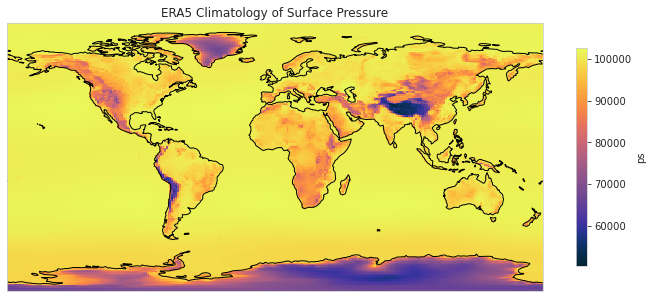

In [5]:
plot_climatology(ps.ps, title="ERA5 Climatology of Surface Pressure")

In [5]:
ha1 = xr.open_dataset("/home/dhruv/fluxnet/US-Ha1.nc")
wcr = xr.open_dataset("/home/dhruv/fluxnet/US-WCr.nc")
blo = xr.open_dataset("/home/dhruv/fluxnet/US-Blo.nc")
srm = xr.open_dataset("/home/dhruv/fluxnet/US-SRM.nc")

In [167]:
ps.ps.sel(dict(lat=ha1.lat, lon=(ha1.lon+360)), method='nearest').mean().load()

<xarray.DataArray 'ps' ()>
array(98041.0655085)
Coordinates:
    lon      float64 287.5
    lat      float64 42.88

In [168]:
ps.ps.sel(dict(lat=wcr.lat, lon=(wcr.lon+360)), method='nearest').mean().load()

<xarray.DataArray 'ps' ()>
array(95813.50834528)
Coordinates:
    lon      float64 270.0
    lat      float64 45.71

In [169]:
ps.ps.sel(dict(lat=blo.lat, lon=(blo.lon+360)), method='nearest').mean().load()

<xarray.DataArray 'ps' ()>
array(98004.23389231)
Coordinates:
    lon      float64 238.8
    lat      float64 39.11

In [182]:
ps.ps.sel(dict(lat=srm.lat, lon=(srm.lon+360)), method='nearest').mean().load()

<xarray.DataArray 'ps' ()>
array(88812.52691593)
Coordinates:
    lon      float64 248.8
    lat      float64 31.57

In [10]:
def read_ds(level):
    x = glob("/home/data/ERA5/T_day/T_day_{}mb/*.nc".format(level))
    return xr.open_mfdataset(x)

In [3]:
levels = [700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

temp_files = dict()
for level in levels:
    temp_files[level] = glob("/home/data/ERA5/T_day/T_day_{}mb/*.nc".format(level))

In [10]:
for level in levels:
    if level == 1000:
        continue
    for i in temp_files[level]:
        temp = xr.open_dataset(i)
        year = i[-13:-9]
        num_days = len(temp.time)
        times = pd.date_range("{}-01-01".format(year), periods=num_days)
        temp['time'] = times
        name = i[-15:]
        temp = temp.expand_dims('level')
        temp.to_netcdf("/home/dhruv/data/temp_ps/ps_{}/".format(level) + name)

In [20]:
# need slightly different indices for the 1000 mb files
for i in temp_files[1000]:
    temp = xr.open_dataset(i)
    year = i[-14:-10]
    num_days = len(temp.time)
    times = pd.date_range("{}-01-01".format(year), periods=num_days)
    temp['time'] = times
    name = i[-16:]
    temp = temp.expand_dims('level')
    temp.to_netcdf("/home/dhruv/data/temp_ps/ps_1000/" + name)

In [4]:
t_files = glob('/home/dhruv/data/temp_ps/*/*.nc')
t = xr.open_mfdataset(t_files)
t

,Array,Chunk
Bytes,81.44 GB,161.91 MB
Shape,"(12, 15341, 192, 288)","(1, 366, 192, 288)"
Count,2016 Tasks,504 Chunks
Type,float64,numpy.ndarray


In [6]:
# t1000_files = glob("/home/dhruv/data/temp_ps/ps_1000/*.nc")
# t_1000 = xr.open_mfdataset(t1000_files)

# t975_files = glob("/home/dhruv/data/temp_ps/ps_975/*.nc")
# t_975 = xr.open_mfdataset(t975_files)

# t950_files = glob("/home/dhruv/data/temp_ps/ps_950/*.nc")
# t_950 = xr.open_mfdataset(t950_files)

# t925_files = glob("/home/dhruv/data/temp_ps/ps_925/*.nc")
# t_925 = xr.open_mfdataset(t925_files)

# t900_files = glob("/home/dhruv/data/temp_ps/ps_900/*.nc")
# t_900 = xr.open_mfdataset(t900_files)

# t875_files = glob("/home/dhruv/data/temp_ps/ps_875/*.nc")
# t_875 = xr.open_mfdataset(t875_files)

# t850_files = glob("/home/dhruv/data/temp_ps/ps_850/*.nc")
# t_850 = xr.open_mfdataset(t850_files)

t_files = glob('/home/dhruv/data/temp_ps/*/*.nc')
t = xr.open_mfdataset(t_files, combine='nested', concat_dim=['time', 'level'])
t

KeyboardInterrupt: 

In [5]:
def jja_std_anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    jja_std = anoms.sel(time=anoms['time.season']=='JJA').std()
    std_anoms = anoms/jja_std
    return std_anoms

In [6]:
def anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    return anoms

In [7]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_annual_cycle(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.year').map(remove_time_mean)

In [8]:
t2m_files = ["/home/data/ERA5/day/T2m_day/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files).load()

In [12]:
def vertical_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    hw_t2m = t2m_anoms.sel(time=heatwave_days).mean().compute().item()
      
    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        t_level = t.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        t_level_anoms = remove_annual_cycle(jja_std_anoms(t_level.T))
        vert_profile[level] = t_level_anoms.sel(time=heatwave_days).mean().compute().item()
        
    plt.scatter(vert_profile.values(), vert_profile.keys())
    plt.scatter(hw_t2m, surface_pressure, color='r')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of temperature anomalies during heatwaves at"
          "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

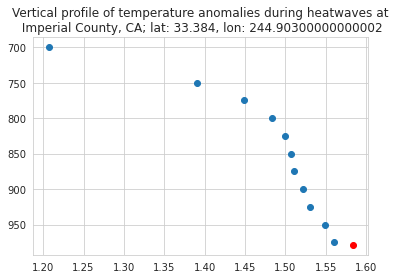

In [13]:
vertical_profile(33.384, -115.097, "Imperial County, CA")

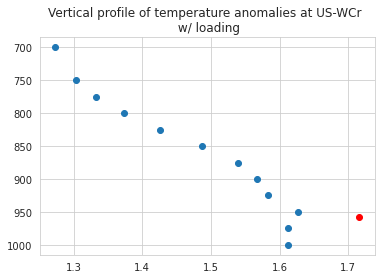

In [12]:
vertical_profile(wcr.lat.item(), wcr.lon.item(), "Vertical profile of temperature anomalies at US-WCr \n w/ loading")

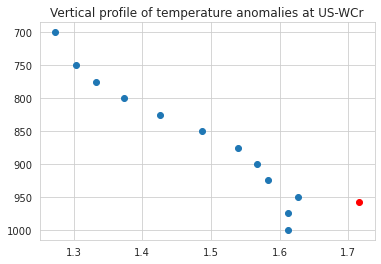

In [24]:
vertical_profile(wcr.lat.item(), wcr.lon.item(), "Vertical profile of temperature anomalies at US-WCr")

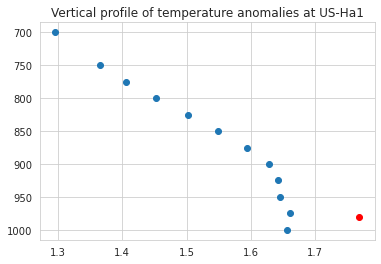

In [25]:
vertical_profile(ha1.lat.item(), ha1.lon.item(), "Vertical profile of temperature anomalies at US-Ha1")

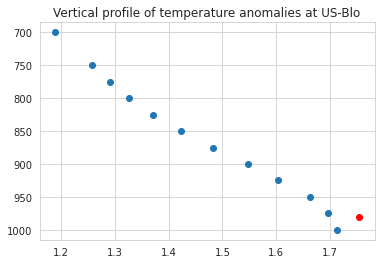

In [26]:
vertical_profile(blo.lat.item(), blo.lon.item(), "Vertical profile of temperature anomalies at US-Blo")

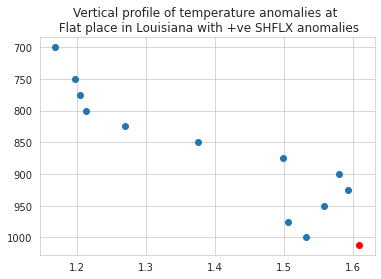

In [27]:
vertical_profile(30.53, -93.26, "Vertical profile of temperature anomalies at \n Flat place in Louisiana with +ve SHFLX anomalies")

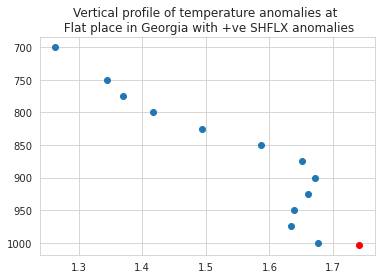

In [28]:
vertical_profile(32.21, -83.73, "Vertical profile of temperature anomalies at \n Flat place in Georgia with +ve SHFLX anomalies")

In [10]:
stations = glob("/home/dhruv/fluxnet/*.nc")
NH_stations = []

for i in stations:
    temp = xr.open_dataset(i)
    lat, lon = temp.lat.item(), temp.lon.item()
    if (lon > -135 and lon < -60) and (lat > 23 and lat < 70):
        NH_stations.append(i)
        print(i)

/home/dhruv/fluxnet/US-WCr.nc
/home/dhruv/fluxnet/US-Var.nc
/home/dhruv/fluxnet/US-UMB.nc
/home/dhruv/fluxnet/US-Ha1.nc
/home/dhruv/fluxnet/US-Ne3.nc
/home/dhruv/fluxnet/US-GLE.nc
/home/dhruv/fluxnet/US-Blo.nc
/home/dhruv/fluxnet/CA-Man.nc
/home/dhruv/fluxnet/US-NR1.nc
/home/dhruv/fluxnet/US-SRM.nc
/home/dhruv/fluxnet/US-Syv.nc
/home/dhruv/fluxnet/CA-Oas.nc
/home/dhruv/fluxnet/CA-Gro.nc
/home/dhruv/fluxnet/CA-TP4.nc
/home/dhruv/fluxnet/CA-TP1.nc
/home/dhruv/fluxnet/US-Me2.nc
/home/dhruv/fluxnet/US-Oho.nc
/home/dhruv/fluxnet/US-Los.nc
/home/dhruv/fluxnet/CA-Obs.nc
/home/dhruv/fluxnet/US-MMS.nc
/home/dhruv/fluxnet/US-Ne2.nc
/home/dhruv/fluxnet/US-Wkg.nc
/home/dhruv/fluxnet/US-ARM.nc
/home/dhruv/fluxnet/CA-TP3.nc
/home/dhruv/fluxnet/US-Ton.nc


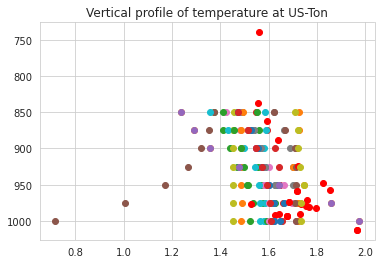

In [15]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    vertical_profile(ds.lat.item(), ds.lon.item(), "Vertical profile of temperature at " + name)

In [9]:
def pre_hw_vertical_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    pre_hw_t2m = t2m_anoms.sel(time=pre_hw_days).mean().compute().item()
      
    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        t_level = t.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest')
        t_level_anoms = remove_annual_cycle(jja_std_anoms(t_level.T))
        vert_profile[level] = t_level_anoms.sel(time=pre_hw_days).mean().compute().item()
        
    plt.scatter(vert_profile.values(), vert_profile.keys())
    plt.scatter(pre_hw_t2m, surface_pressure, color='r')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of temperature anomalies 5 days before heatwaves at"
          "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

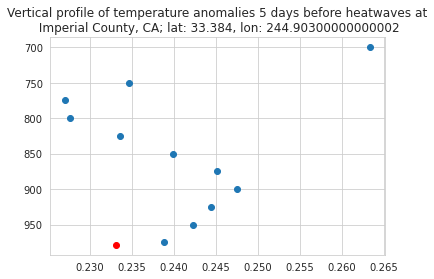

In [16]:
pre_hw_vertical_profile(33.384, -115.097, "Imperial County, CA")

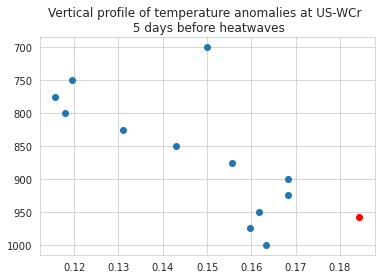

In [30]:
pre_hw_vertical_profile(wcr.lat.item(), wcr.lon.item(), "Vertical profile of temperature anomalies at US-WCr \n 5 days before heatwaves")

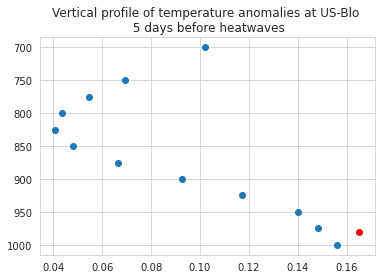

In [31]:
pre_hw_vertical_profile(blo.lat.item(), blo.lon.item(), "Vertical profile of temperature anomalies at US-Blo \n 5 days before heatwaves")

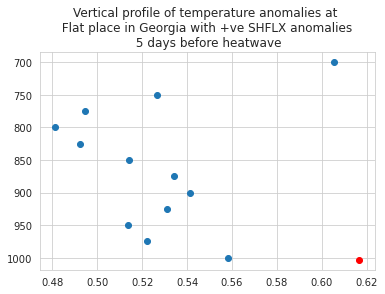

In [32]:
pre_hw_vertical_profile(32.21, -83.73, "Vertical profile of temperature anomalies at \n Flat place in Georgia with +ve SHFLX anomalies \n 5 days before heatwave")

In [11]:
def full_vertical_profile(lat, lon, title=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    hw_t2m = t2m_data.sel(time=heatwave_days).mean().compute().item()
    pre_hw_t2m = t2m_data.sel(time=pre_hw_days).mean().compute().item()
    
    hw_t2m_anoms = t2m_anoms.sel(time=heatwave_days).mean().compute().item()
    pre_hw_t2m_anoms = t2m_anoms.sel(time=pre_hw_days).mean().compute().item()
      
    pre_t, pre_t_anoms, pre_t_pot, pre_t_pot_anoms = dict(), dict(), dict(), dict()
    tp, tp_anoms, tp_pot, tp_pot_anoms = dict(), dict(), dict(), dict()
    
    for level in levels:
        t_level = t.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').T
        t_pot = t_level*(1000./level)**(0.286)
        t_level_anoms = remove_annual_cycle(jja_std_anoms(t_level))
        t_pot_anoms = t_level_anoms*(1000./level)**(0.286)
        
        pre_t[level] = t_level.sel(time=pre_hw_days).mean().compute().item()
        pre_t_anoms[level] = t_level_anoms.sel(time=pre_hw_days).mean().compute().item()
        pre_t_pot[level] = t_pot.sel(time=pre_hw_days).mean().compute().item()
        pre_t_pot_anoms[level] = t_pot_anoms.sel(time=pre_hw_days).mean().compute().item()
        
        tp[level] = t_level.sel(time=heatwave_days).mean().compute().item()
        tp_anoms[level] = t_level_anoms.sel(time=heatwave_days).mean().compute().item()
        tp_pot[level] = t_pot.sel(time=heatwave_days).mean().compute().item()
        tp_pot_anoms[level] = t_pot_anoms.sel(time=heatwave_days).mean().compute().item()
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 8))
    
    ax[0,0].scatter(pre_t.values(), pre_t.keys())
    ax[0,0].scatter(pre_hw_t2m, surface_pressure, color='r')
    ax[0,0].invert_yaxis()
    ax[0,0].set_title("temp")
    
    ax[0,1].scatter(pre_t_anoms.values(), pre_t_anoms.keys())
    ax[0,1].scatter(pre_hw_t2m_anoms, surface_pressure, color='r')
    ax[0,1].invert_yaxis()
    ax[0,1].set_title("temp anoms")
    
    ax[0,2].scatter(pre_t_pot.values(), pre_t_pot.keys())
    ax[0,2].invert_yaxis()
    ax[0,2].set_title("pot temp")
    
    ax[0,3].scatter(pre_t_pot_anoms.values(), pre_t_pot_anoms.keys())
    ax[0,3].invert_yaxis()
    ax[0,3].set_title("pot temp anoms")
    
    ax[1,0].scatter(tp.values(), tp.keys())
    ax[1,0].scatter(hw_t2m, surface_pressure, color='r')
    ax[1,0].invert_yaxis()
    ax[1,0].set_title("temp")
    
    ax[1,1].scatter(tp_anoms.values(), tp_anoms.keys())
    ax[1,1].scatter(hw_t2m_anoms, surface_pressure, color='r')
    ax[1,1].invert_yaxis()
    ax[1,1].set_title("temp anoms")
    
    ax[1,2].scatter(tp_pot.values(), tp_pot.keys())
    ax[1,2].invert_yaxis()
    ax[1,2].set_title("temp pot")
    
    ax[1,3].scatter(tp_pot_anoms.values(), tp_pot_anoms.keys())
    ax[1,3].invert_yaxis()
    ax[1,3].set_title("temp pot anoms")
    
    fig.tight_layout()
    fig.suptitle(title)

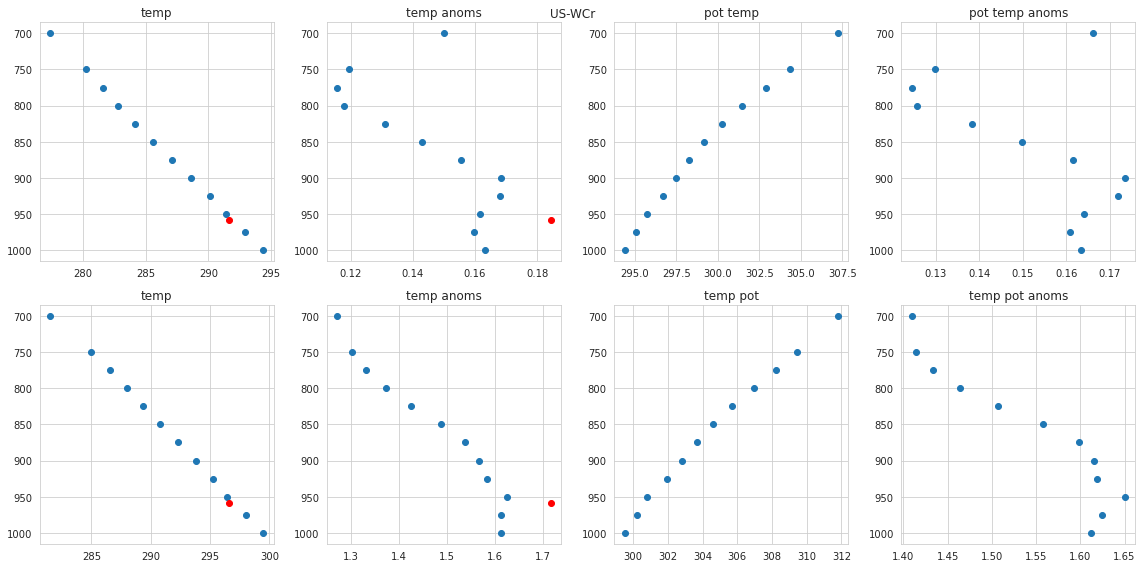

In [22]:
full_vertical_profile(wcr.lat.item(), wcr.lon.item(), "US-WCr")

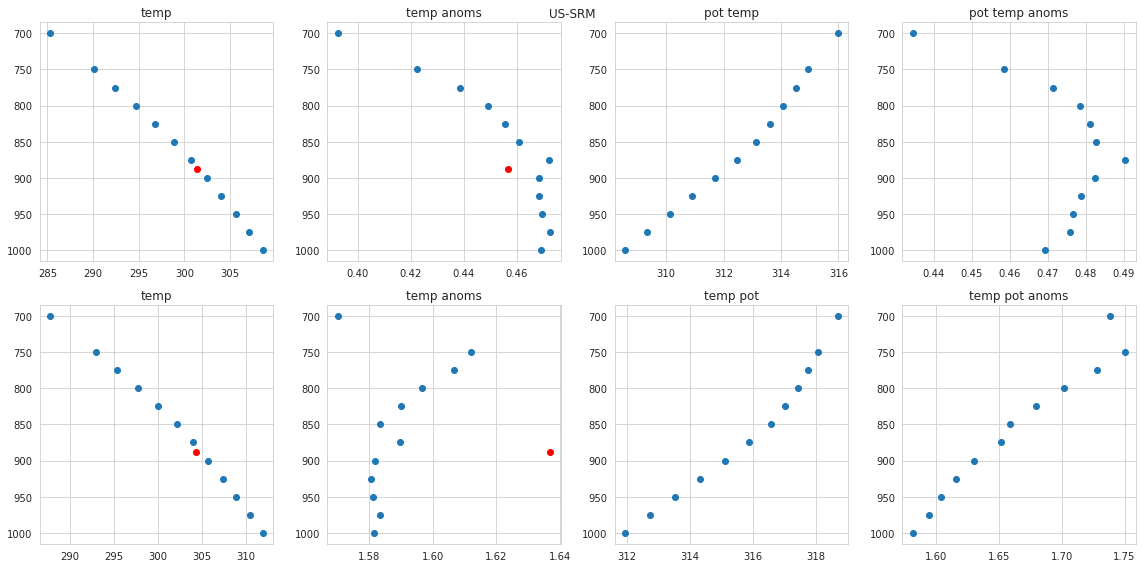

In [11]:
full_vertical_profile(srm.lat.item(), srm.lon.item(), "US-SRM")

In [98]:
obs = xr.open_dataset("/home/dhruv/fluxnet/CA-Obs.nc")

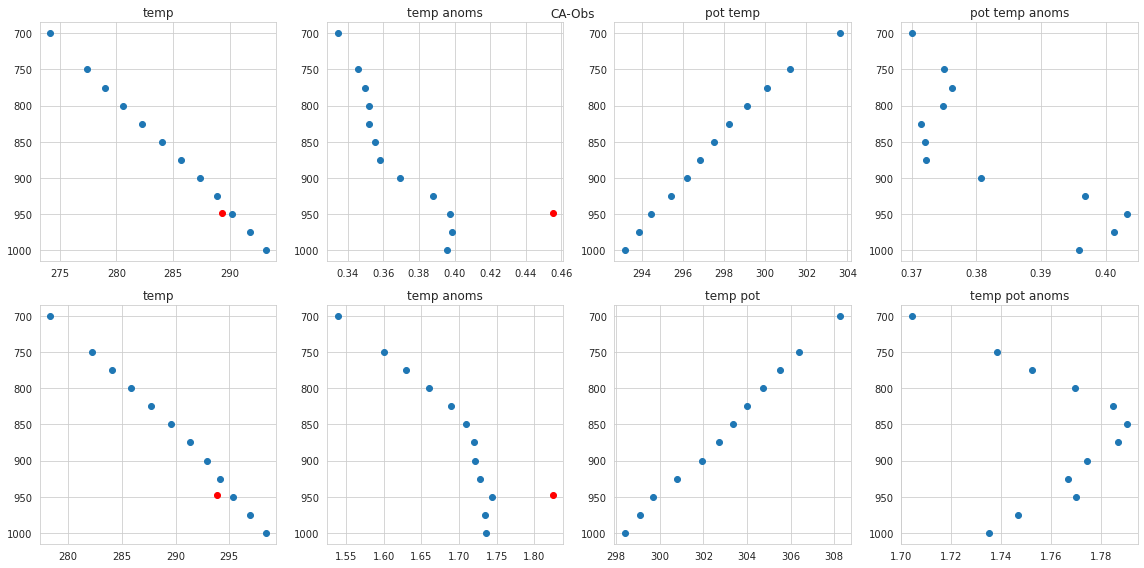

In [13]:
full_vertical_profile(obs.lat.item(), obs.lon.item(), "CA-Obs")

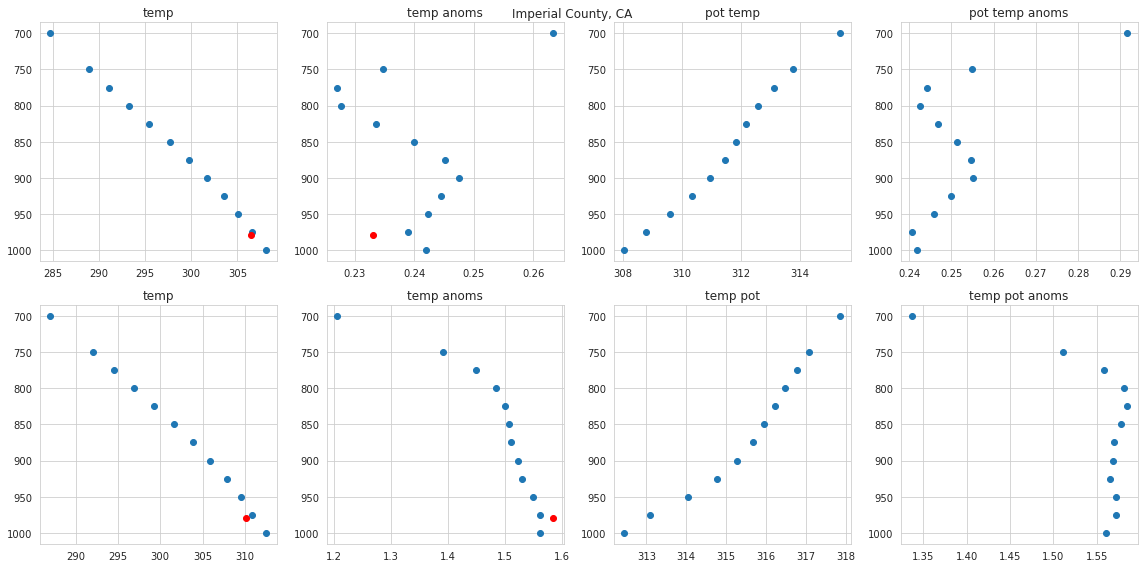

In [14]:
full_vertical_profile(33.384, -115.097, "Imperial County, CA")

In [16]:
oas = xr.open_dataset("/home/dhruv/fluxnet/CA-Oas.nc")

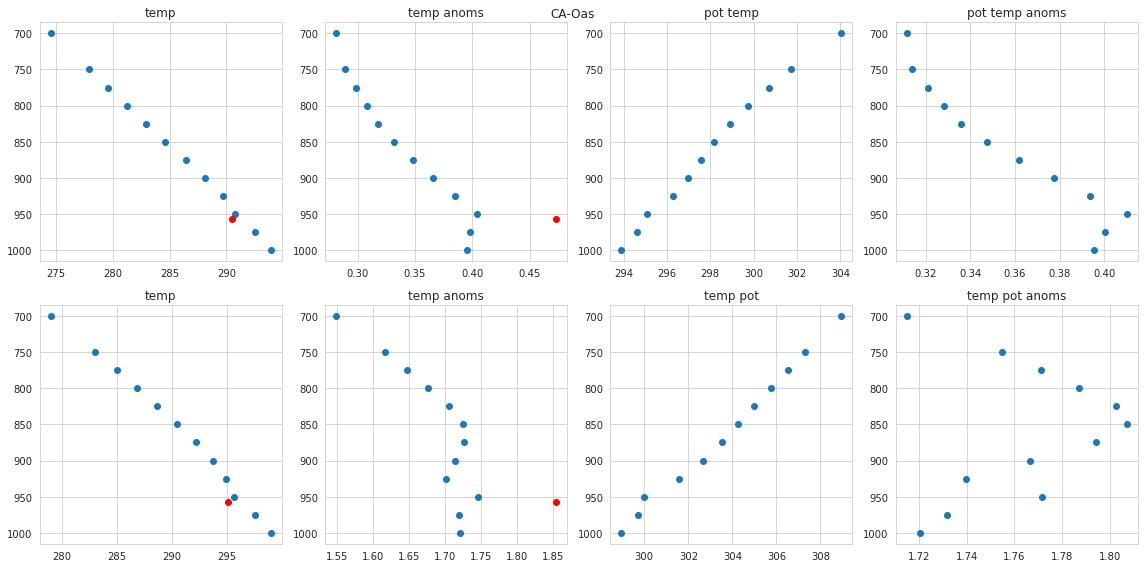

In [16]:
full_vertical_profile(oas.lat.item(), oas.lon.item(), "CA-Oas")

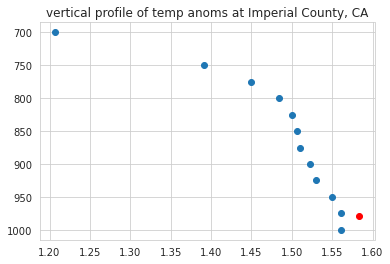

In [12]:
vertical_profile(33.384, -115.097, "vertical profile of temp anoms at Imperial County, CA")

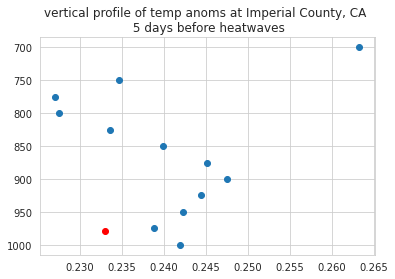

In [13]:
pre_hw_vertical_profile(33.384, -115.097, "vertical profile of temp anoms at Imperial County, CA \n 5 days before heatwaves")

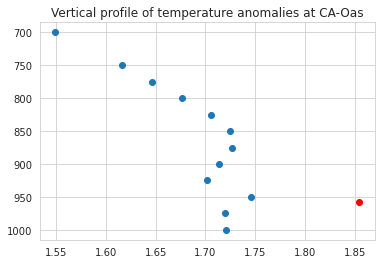

In [17]:
vertical_profile(oas.lat.item(), oas.lon.item(), "Vertical profile of temperature anomalies at CA-Oas")

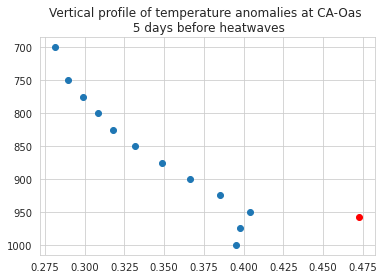

In [18]:
pre_hw_vertical_profile(oas.lat.item(), oas.lon.item(), "Vertical profile of temperature anomalies at CA-Oas \n 5 days before heatwaves")

In [52]:
t2m_data = t2m.t2m.sel(dict(lat=wcr.lat.item(), lon=wcr.lon.item()), method='nearest')
t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')

heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]

In [53]:
t850 = t.sel(level=850).sel(time=heatwave_days).mean('time').T * units.K

u_files = glob('/home/data/ERA5/U_day/U_850mb/*.nc')
u = xr.open_mfdataset(u_files).sel(time=heatwave_days).mean('time').U * units('m/s')

v_files = glob('/home/data/ERA5/V_day/V_850mb/*.nc')
v = xr.open_mfdataset(v_files).sel(time=heatwave_days).mean('time').V * units('m/s')

In [54]:
dx, dy = mpcalc.lat_lon_grid_deltas(t.lon.values, t.lat.values)
adv = mpcalc.advection(t850, u=u, v=v, dx=dx, dy=dy)

/home/dhruv/my_venv/lib/python3.9/site-packages/metpy/xarray.py:1471: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/dhruv/my_venv/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/dhruv/my_venv/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/dhruv/my_venv/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/dhruv/my_venv/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/dhruv/my_venv/lib/python3.9/site-packages/pin

In [72]:
adv = adv.metpy.convert_units(units('delta_degC/hour'))
adv

<xarray.DataArray 'neg-e690404355eb37d874252d581c51abb8' (lat: 192, lon: 288)>
<Quantity(dask.array<mul, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>, 'delta_degree_Celsius / hour')>
Coordinates:
    level    float64 850.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

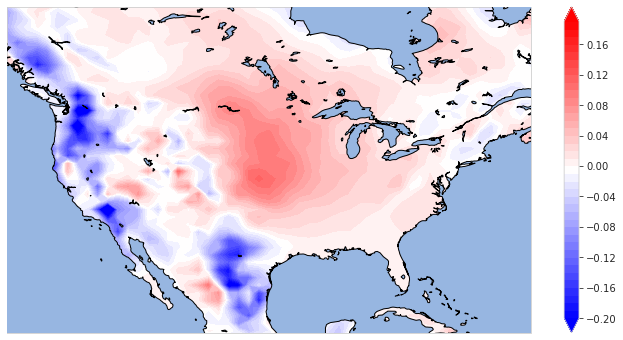

In [90]:
extent = [-130, -65, 20, 60.5]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# offset = colors.TwoSlopeNorm(vmin=adv.min().values + 0.2, vcenter=0, vmax=adv.max().values-0.2)
# offset = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cf = plt.contourf(adv.lon, adv.lat, adv, cmap='bwr', levels=np.arange(-0.2, 0.2, .01), extend='both')
plt.colorbar(cf)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.add_feature(cfeature.LAKES, edgecolor='black')
# plt.title('ERA5 Sensible heat anomalies'
#          '\n Days selected from top 10% of heatwave anomalies')

plt.show()

In [111]:
swvl_files = glob("/home/data/ERA5/swvl1_day/*.nc")
swvl = xr.open_mfdataset(swvl_files).SWVL1
swvl

<xarray.DataArray 'SWVL1' (time: 15341, lat: 192, lon: 288)>
dask.array<concatenate, shape=(15341, 192, 288), dtype=float64, chunksize=(366, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
Attributes:
    regrid_method:  bilinear

In [115]:
z_files = glob("/home/data/ERA5/Z_day/*.nc")
z = xr.open_mfdataset(z_files).Z
z

<xarray.DataArray 'Z' (time: 15341, lat: 192, lon: 288)>
dask.array<concatenate, shape=(15341, 192, 288), dtype=float64, chunksize=(366, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    level    float64 500.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [124]:
t

<xarray.DataArray (time: 3772)>
array([-1.27911277, -0.36913493,  0.83504129, ..., -0.50920359,
       -1.50694682, -1.24308583])
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-08-31
    lon      float64 345.0
    lat      float64 35.34
    daystr   (time) <U5 '06-01' '06-02' '06-03' ... '08-29' '08-30' '08-31'

In [126]:
t850 = t.sel(level=850).T.load()
t850

<xarray.DataArray 'T' (time: 15341, lat: 192, lon: 288)>
array([[[260.04849243, 260.04849243, 260.04849243, ..., 260.04849243,
         260.04849243, 260.04849243],
        [259.93065065, 259.94532833, 259.96073379, ..., 259.88997008,
         259.90288237, 259.91649433],
        [259.90504544, 259.93449793, 259.96503676, ..., 259.83273859,
         259.8538411 , 259.87796372],
        ...,
        [247.00158286, 246.98793192, 246.97486416, ..., 247.04279405,
         247.02934547, 247.01556726],
        [248.34877858, 248.350033  , 248.35283598, ..., 248.35223282,
         248.35000056, 248.34870285],
        [250.04711914, 250.04711914, 250.04711914, ..., 250.04711914,
         250.04711914, 250.04711914]],

       [[259.08688354, 259.08688354, 259.08688354, ..., 259.08688354,
         259.08688354, 259.08688354],
        [258.61490989, 258.62810946, 258.64171519, ..., 258.57931409,
         258.59069907, 258.60269407],
        [258.576281  , 258.59193588, 258.60557021, ..., 258.52505285,
         258.5419842 , 258.55941101],
...
        [259.44134377, 259.52237289, 259.602664  , ..., 259.20974507,
         259.28380053, 259.3613981 ],
        [258.59829431, 258.63109095, 258.66309383, ..., 258.49689415,
         258.53104811, 258.56487788],
        [257.67495728, 257.67495728, 257.67495728, ..., 257.67495728,
         257.67495728, 257.67495728]],

       [[253.207901  , 253.207901  , 253.207901  , ..., 253.207901  ,
         253.207901  , 253.207901  ],
        [253.7409578 , 253.73607619, 253.72998402, ..., 253.74908922,
         253.74751381, 253.74484863],
        [254.23616203, 254.23459796, 254.23088105, ..., 254.24085103,
         254.23834907, 254.23698265],
        ...,
        [260.38292337, 260.41313881, 260.44172755, ..., 260.29544641,
         260.32307057, 260.35269419],
        [259.33053473, 259.35119337, 259.37247195, ..., 259.27530957,
         259.29250008, 259.31089978],
        [258.85787964, 258.85787964, 258.85787964, ..., 258.85787964,
         258.85787964, 258.85787964]]])
Coordinates:
    level    float64 850.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [133]:
all_lats = t2m.lat.values
all_lons = t2m.lon.values

extent = [-135, -60, 23, 70]
extent_lats, extent_lons = [], []

for lat in all_lats:
    if lat >= 23 and lat <= 70:
        print(lat)
        extent_lats.append(lat)
        
for lon in all_lons:
    if lon >= (-135+360) and lon <= (-60+360):
        print(lon)
        extent_lons.append(lon)

23.089005235602087
24.031413612565444
24.9738219895288
25.916230366492144
26.8586387434555
27.801047120418843
28.7434554973822
29.685863874345543
30.6282722513089
31.570680628272257
32.5130890052356
33.455497382198956
34.3979057591623
35.340314136125656
36.282722513089
37.225130890052355
38.16753926701571
39.10994764397907
40.0523560209424
40.994764397905755
41.93717277486911
42.87958115183247
43.8219895287958
44.764397905759154
45.70680628272251
46.64921465968587
47.591623036649224
48.53403141361255
49.47643979057591
50.41884816753927
51.36125654450262
52.30366492146598
53.24607329842931
54.188481675392666
55.13089005235602
56.07329842931938
57.01570680628271
57.958115183246065
58.90052356020942
59.84293193717278
60.785340314136135
61.727748691099464
62.67015706806282
63.61256544502618
64.55497382198953
65.49738219895289
66.43979057591622
67.38219895287958
68.32460732984293
69.26701570680629
225.0
226.25
227.5
228.75
230.0
231.25
232.5
233.75
235.0
236.25
237.5
238.75
240.0
241.25
242

In [189]:
lat=[]
lon=[]
std_anoms_t850 = []
# std_anoms_swvl = []
# std_anoms_z = []

for latitude in extent_lats:
    for longitude in extent_lons:
        print(latitude, longitude)
        
        s_t2m = t2m.t2m.sel(lat=latitude,lon=longitude)
        s_t850 = t850.sel(lat=latitude,lon=longitude)
#         s_z = z.sel(lat=latitude,lon=longitude)
#         s_swvl = swvl.sel(lat=latitude,lon=longitude)
        
        subset_anoms_t850 = remove_annual_cycle(jja_std_anoms(s_t850))
#         subset_anoms_z = remove_annual_cycle(jja_std_anoms(s_z)).load() # the anomalies, standardized by JJA sd
#         subset_anoms_swvl = remove_annual_cycle(jja_std_anoms(s_swvl)).load()
       
      #  subset_anoms_t2m = std_anoms(subset['T2MMEAN'])
        s_t2m_anoms = remove_annual_cycle(jja_std_anoms(s_t2m))   # anomalies, not standardized, just JJA
        s_t2m_anoms = s_t2m_anoms.sel({'time':s_t2m_anoms['time.season']=='JJA'})
        heatwave_days = s_t2m_anoms[s_t2m_anoms>=s_t2m_anoms.quantile(0.9)].time.values
        pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]
        
        std_anoms_t850.append(subset_anoms_t850.sel(time=pre_hw_days).mean().item())
#         std_anoms_z.append(subset_anoms_z.sel(time=heatwave_days).mean().item())
#         std_anoms_swvl.append(subset_anoms_swvl.sel(time=heatwave_days).mean().item())

        lat.append(latitude)
        lon.append(longitude)
        
df = pd.DataFrame({'lat':lat,'lon':lon,'std_anoms_t850_pre_hw':std_anoms_t850})

23.089005235602087 225.0
23.089005235602087 226.25
23.089005235602087 227.5
23.089005235602087 228.75
23.089005235602087 230.0
23.089005235602087 231.25
23.089005235602087 232.5
23.089005235602087 233.75
23.089005235602087 235.0
23.089005235602087 236.25
23.089005235602087 237.5
23.089005235602087 238.75
23.089005235602087 240.0
23.089005235602087 241.25
23.089005235602087 242.5
23.089005235602087 243.75
23.089005235602087 245.0
23.089005235602087 246.25
23.089005235602087 247.5
23.089005235602087 248.75
23.089005235602087 250.0
23.089005235602087 251.25
23.089005235602087 252.5
23.089005235602087 253.75
23.089005235602087 255.0
23.089005235602087 256.25
23.089005235602087 257.5
23.089005235602087 258.75
23.089005235602087 260.0
23.089005235602087 261.25
23.089005235602087 262.5
23.089005235602087 263.75
23.089005235602087 265.0
23.089005235602087 266.25
23.089005235602087 267.5
23.089005235602087 268.75
23.089005235602087 270.0
23.089005235602087 271.25
23.089005235602087 272.5
23.089

27.801047120418843 257.5
27.801047120418843 258.75
27.801047120418843 260.0
27.801047120418843 261.25
27.801047120418843 262.5
27.801047120418843 263.75
27.801047120418843 265.0
27.801047120418843 266.25
27.801047120418843 267.5
27.801047120418843 268.75
27.801047120418843 270.0
27.801047120418843 271.25
27.801047120418843 272.5
27.801047120418843 273.75
27.801047120418843 275.0
27.801047120418843 276.25
27.801047120418843 277.5
27.801047120418843 278.75
27.801047120418843 280.0
27.801047120418843 281.25
27.801047120418843 282.5
27.801047120418843 283.75
27.801047120418843 285.0
27.801047120418843 286.25
27.801047120418843 287.5
27.801047120418843 288.75
27.801047120418843 290.0
27.801047120418843 291.25
27.801047120418843 292.5
27.801047120418843 293.75
27.801047120418843 295.0
27.801047120418843 296.25
27.801047120418843 297.5
27.801047120418843 298.75
27.801047120418843 300.0
28.7434554973822 225.0
28.7434554973822 226.25
28.7434554973822 227.5
28.7434554973822 228.75
28.74345549738

32.5130890052356 296.25
32.5130890052356 297.5
32.5130890052356 298.75
32.5130890052356 300.0
33.455497382198956 225.0
33.455497382198956 226.25
33.455497382198956 227.5
33.455497382198956 228.75
33.455497382198956 230.0
33.455497382198956 231.25
33.455497382198956 232.5
33.455497382198956 233.75
33.455497382198956 235.0
33.455497382198956 236.25
33.455497382198956 237.5
33.455497382198956 238.75
33.455497382198956 240.0
33.455497382198956 241.25
33.455497382198956 242.5
33.455497382198956 243.75
33.455497382198956 245.0
33.455497382198956 246.25
33.455497382198956 247.5
33.455497382198956 248.75
33.455497382198956 250.0
33.455497382198956 251.25
33.455497382198956 252.5
33.455497382198956 253.75
33.455497382198956 255.0
33.455497382198956 256.25
33.455497382198956 257.5
33.455497382198956 258.75
33.455497382198956 260.0
33.455497382198956 261.25
33.455497382198956 262.5
33.455497382198956 263.75
33.455497382198956 265.0
33.455497382198956 266.25
33.455497382198956 267.5
33.45549738219

38.16753926701571 257.5
38.16753926701571 258.75
38.16753926701571 260.0
38.16753926701571 261.25
38.16753926701571 262.5
38.16753926701571 263.75
38.16753926701571 265.0
38.16753926701571 266.25
38.16753926701571 267.5
38.16753926701571 268.75
38.16753926701571 270.0
38.16753926701571 271.25
38.16753926701571 272.5
38.16753926701571 273.75
38.16753926701571 275.0
38.16753926701571 276.25
38.16753926701571 277.5
38.16753926701571 278.75
38.16753926701571 280.0
38.16753926701571 281.25
38.16753926701571 282.5
38.16753926701571 283.75
38.16753926701571 285.0
38.16753926701571 286.25
38.16753926701571 287.5
38.16753926701571 288.75
38.16753926701571 290.0
38.16753926701571 291.25
38.16753926701571 292.5
38.16753926701571 293.75
38.16753926701571 295.0
38.16753926701571 296.25
38.16753926701571 297.5
38.16753926701571 298.75
38.16753926701571 300.0
39.10994764397907 225.0
39.10994764397907 226.25
39.10994764397907 227.5
39.10994764397907 228.75
39.10994764397907 230.0
39.10994764397907 231

42.87958115183247 295.0
42.87958115183247 296.25
42.87958115183247 297.5
42.87958115183247 298.75
42.87958115183247 300.0
43.8219895287958 225.0
43.8219895287958 226.25
43.8219895287958 227.5
43.8219895287958 228.75
43.8219895287958 230.0
43.8219895287958 231.25
43.8219895287958 232.5
43.8219895287958 233.75
43.8219895287958 235.0
43.8219895287958 236.25
43.8219895287958 237.5
43.8219895287958 238.75
43.8219895287958 240.0
43.8219895287958 241.25
43.8219895287958 242.5
43.8219895287958 243.75
43.8219895287958 245.0
43.8219895287958 246.25
43.8219895287958 247.5
43.8219895287958 248.75
43.8219895287958 250.0
43.8219895287958 251.25
43.8219895287958 252.5
43.8219895287958 253.75
43.8219895287958 255.0
43.8219895287958 256.25
43.8219895287958 257.5
43.8219895287958 258.75
43.8219895287958 260.0
43.8219895287958 261.25
43.8219895287958 262.5
43.8219895287958 263.75
43.8219895287958 265.0
43.8219895287958 266.25
43.8219895287958 267.5
43.8219895287958 268.75
43.8219895287958 270.0
43.821989

48.53403141361255 253.75
48.53403141361255 255.0
48.53403141361255 256.25
48.53403141361255 257.5
48.53403141361255 258.75
48.53403141361255 260.0
48.53403141361255 261.25
48.53403141361255 262.5
48.53403141361255 263.75
48.53403141361255 265.0
48.53403141361255 266.25
48.53403141361255 267.5
48.53403141361255 268.75
48.53403141361255 270.0
48.53403141361255 271.25
48.53403141361255 272.5
48.53403141361255 273.75
48.53403141361255 275.0
48.53403141361255 276.25
48.53403141361255 277.5
48.53403141361255 278.75
48.53403141361255 280.0
48.53403141361255 281.25
48.53403141361255 282.5
48.53403141361255 283.75
48.53403141361255 285.0
48.53403141361255 286.25
48.53403141361255 287.5
48.53403141361255 288.75
48.53403141361255 290.0
48.53403141361255 291.25
48.53403141361255 292.5
48.53403141361255 293.75
48.53403141361255 295.0
48.53403141361255 296.25
48.53403141361255 297.5
48.53403141361255 298.75
48.53403141361255 300.0
49.47643979057591 225.0
49.47643979057591 226.25
49.47643979057591 22

53.24607329842931 291.25
53.24607329842931 292.5
53.24607329842931 293.75
53.24607329842931 295.0
53.24607329842931 296.25
53.24607329842931 297.5
53.24607329842931 298.75
53.24607329842931 300.0
54.188481675392666 225.0
54.188481675392666 226.25
54.188481675392666 227.5
54.188481675392666 228.75
54.188481675392666 230.0
54.188481675392666 231.25
54.188481675392666 232.5
54.188481675392666 233.75
54.188481675392666 235.0
54.188481675392666 236.25
54.188481675392666 237.5
54.188481675392666 238.75
54.188481675392666 240.0
54.188481675392666 241.25
54.188481675392666 242.5
54.188481675392666 243.75
54.188481675392666 245.0
54.188481675392666 246.25
54.188481675392666 247.5
54.188481675392666 248.75
54.188481675392666 250.0
54.188481675392666 251.25
54.188481675392666 252.5
54.188481675392666 253.75
54.188481675392666 255.0
54.188481675392666 256.25
54.188481675392666 257.5
54.188481675392666 258.75
54.188481675392666 260.0
54.188481675392666 261.25
54.188481675392666 262.5
54.18848167539

58.90052356020942 246.25
58.90052356020942 247.5
58.90052356020942 248.75
58.90052356020942 250.0
58.90052356020942 251.25
58.90052356020942 252.5
58.90052356020942 253.75
58.90052356020942 255.0
58.90052356020942 256.25
58.90052356020942 257.5
58.90052356020942 258.75
58.90052356020942 260.0
58.90052356020942 261.25
58.90052356020942 262.5
58.90052356020942 263.75
58.90052356020942 265.0
58.90052356020942 266.25
58.90052356020942 267.5
58.90052356020942 268.75
58.90052356020942 270.0
58.90052356020942 271.25
58.90052356020942 272.5
58.90052356020942 273.75
58.90052356020942 275.0
58.90052356020942 276.25
58.90052356020942 277.5
58.90052356020942 278.75
58.90052356020942 280.0
58.90052356020942 281.25
58.90052356020942 282.5
58.90052356020942 283.75
58.90052356020942 285.0
58.90052356020942 286.25
58.90052356020942 287.5
58.90052356020942 288.75
58.90052356020942 290.0
58.90052356020942 291.25
58.90052356020942 292.5
58.90052356020942 293.75
58.90052356020942 295.0
58.90052356020942 29

63.61256544502618 277.5
63.61256544502618 278.75
63.61256544502618 280.0
63.61256544502618 281.25
63.61256544502618 282.5
63.61256544502618 283.75
63.61256544502618 285.0
63.61256544502618 286.25
63.61256544502618 287.5
63.61256544502618 288.75
63.61256544502618 290.0
63.61256544502618 291.25
63.61256544502618 292.5
63.61256544502618 293.75
63.61256544502618 295.0
63.61256544502618 296.25
63.61256544502618 297.5
63.61256544502618 298.75
63.61256544502618 300.0
64.55497382198953 225.0
64.55497382198953 226.25
64.55497382198953 227.5
64.55497382198953 228.75
64.55497382198953 230.0
64.55497382198953 231.25
64.55497382198953 232.5
64.55497382198953 233.75
64.55497382198953 235.0
64.55497382198953 236.25
64.55497382198953 237.5
64.55497382198953 238.75
64.55497382198953 240.0
64.55497382198953 241.25
64.55497382198953 242.5
64.55497382198953 243.75
64.55497382198953 245.0
64.55497382198953 246.25
64.55497382198953 247.5
64.55497382198953 248.75
64.55497382198953 250.0
64.55497382198953 251

69.26701570680629 238.75
69.26701570680629 240.0
69.26701570680629 241.25
69.26701570680629 242.5
69.26701570680629 243.75
69.26701570680629 245.0
69.26701570680629 246.25
69.26701570680629 247.5
69.26701570680629 248.75
69.26701570680629 250.0
69.26701570680629 251.25
69.26701570680629 252.5
69.26701570680629 253.75
69.26701570680629 255.0
69.26701570680629 256.25
69.26701570680629 257.5
69.26701570680629 258.75
69.26701570680629 260.0
69.26701570680629 261.25
69.26701570680629 262.5
69.26701570680629 263.75
69.26701570680629 265.0
69.26701570680629 266.25
69.26701570680629 267.5
69.26701570680629 268.75
69.26701570680629 270.0
69.26701570680629 271.25
69.26701570680629 272.5
69.26701570680629 273.75
69.26701570680629 275.0
69.26701570680629 276.25
69.26701570680629 277.5
69.26701570680629 278.75
69.26701570680629 280.0
69.26701570680629 281.25
69.26701570680629 282.5
69.26701570680629 283.75
69.26701570680629 285.0
69.26701570680629 286.25
69.26701570680629 287.5
69.26701570680629 28

In [190]:
df = df.set_index(['lat', 'lon']).to_xarray()
df.to_netcdf("/home/dhruv/data/heatwave_t850_anoms_nh_pre_hw.nc")

# df.to_netcdf("/home/dhruv/data/heatwave_t850_anoms_nh.nc")
# ^ anoms during heatwave are here

In [200]:
extent = [-135, -60, 23, 70]

def plt_anoms(data, cmap='coolwarm'):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    
#     cmax    = 1.
#     cmin    = -1.
#     cint    = (cmax - cmin)/10.
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    plt.contourf(data.lon, data.lat, data.std_anoms_t850_pre_hw, cmap = cmap, 
                 levels = np.arange(-0.2, 0.8, 0.1), extend='both')
    plt.colorbar(shrink = 0.5)

    height = ps.mean('time')
    hatch = height.where(height.ps > 85000, nan)
    hatch['ps'] = hatch.ps.astype(int)
    n_levels = 1
    plt.contourf(hatch.lon, hatch.lat, hatch.ps, n_levels, hatches=['.'], colors='none')
    
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    plt.title('ERA5 pre-heatwave anomalies of temperature at 850 hPa'
             '\n hatching where surface pressure <= 850 hPA')
        
    plt.show()

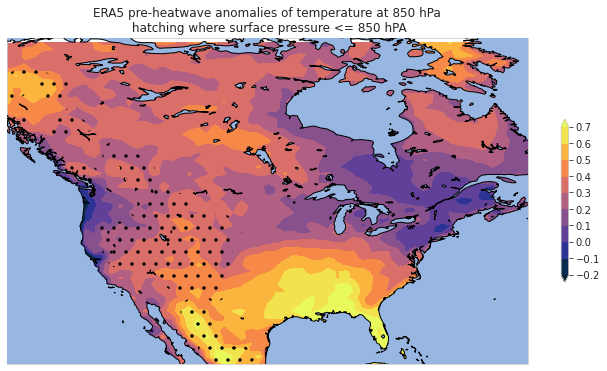

In [201]:
plt_anoms(df, cmap=cmo.thermal)

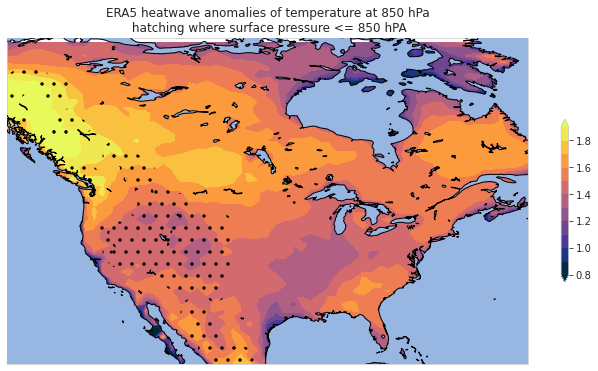

In [188]:
plt_anoms(df, cmap=cmo.thermal)

In [169]:
height = ps.mean('time')
hatch = height.where(height.ps <= 850, True)
hatch = hatch.where(hatch.ps/100. > 850, False)
hatch['ps'] = hatch.ps.astype(int)

In [9]:
def pre_vertical_profile_non_std(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]

    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    t2m_non_std_anoms = remove_annual_cycle(anoms(t2m_data))
    hw_t2m = t2m_non_std_anoms.sel(time=pre_hw_days).mean().compute().item()
      
    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        t_level = t.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        t_level_anoms = remove_annual_cycle(anoms(t_level.T))
        vert_profile[level] = t_level_anoms.sel(time=pre_hw_days).mean().compute().item()
        
    plt.scatter(vert_profile.values(), vert_profile.keys(), color='g')
    plt.scatter(hw_t2m, surface_pressure, color='purple')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of temperature anomalies 5 days before heatwaves at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

In [20]:
def vertical_profile_non_std(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    t2m_non_std_anoms = remove_annual_cycle(anoms(t2m_data))
    hw_t2m = t2m_non_std_anoms.sel(time=heatwave_days).mean().compute().item()
    
    t_local = t.sel(dict(lat=lat, lon=lon), method='nearest').load()
      
    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        t_level = t_local.sel(level=level)
        t_level_anoms = remove_annual_cycle(anoms(t_level.T))
        vert_profile[level] = t_level_anoms.sel(time=heatwave_days).mean().compute().item()
        
    plt.scatter(vert_profile.values(), vert_profile.keys(), color='g')
    plt.scatter(hw_t2m, surface_pressure, color='purple')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of temperature anomalies during heatwave days at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

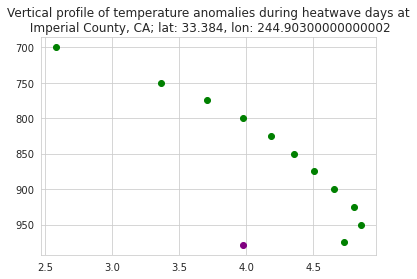

In [15]:
vertical_profile_non_std(33.384, -115.097, "Imperial County, CA")

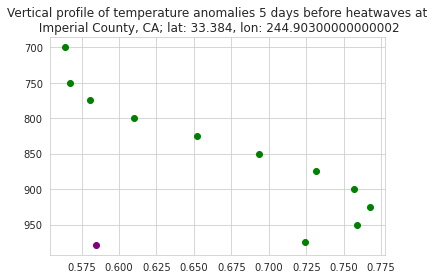

In [16]:
pre_vertical_profile_non_std(33.384, -115.097, "Imperial County, CA")

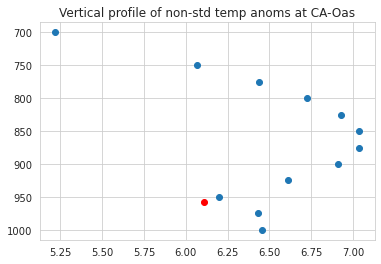

In [17]:
vertical_profile_non_std(oas.lat.item(), oas.lon.item(), "Vertical profile of non-std temp anoms at CA-Oas")

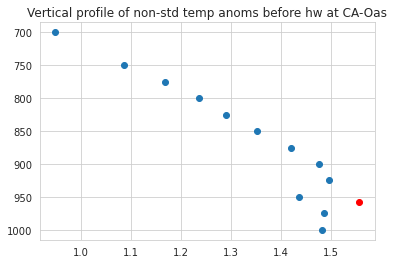

In [18]:
pre_vertical_profile_non_std(oas.lat.item(), oas.lon.item(), "Vertical profile of non-std temp anoms before hw at CA-Oas")

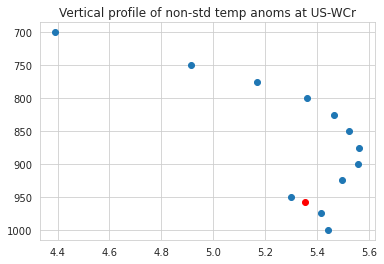

In [19]:
vertical_profile_non_std(wcr.lat.item(), wcr.lon.item(), "Vertical profile of non-std temp anoms at US-WCr")

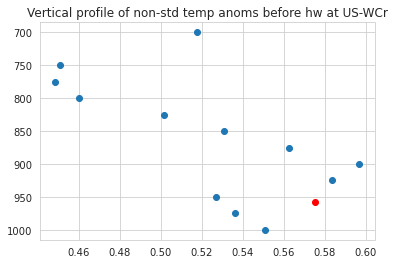

In [21]:
pre_vertical_profile_non_std(wcr.lat.item(), wcr.lon.item(), "Vertical profile of non-std temp anoms before hw at US-WCr")

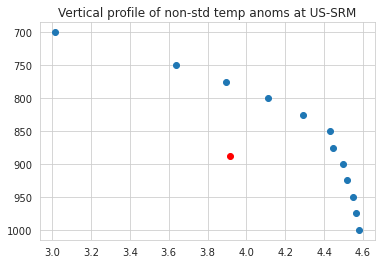

In [20]:
vertical_profile_non_std(srm.lat.item(), srm.lon.item(), "Vertical profile of non-std temp anoms at US-SRM")

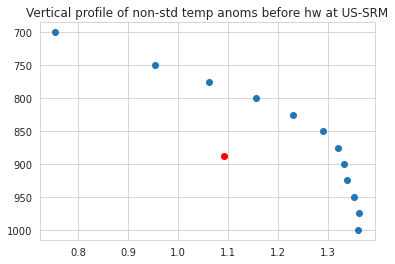

In [22]:
pre_vertical_profile_non_std(srm.lat.item(), srm.lon.item(), "Vertical profile of non-std temp anoms before hw at US-SRM")

In [11]:
outdir="/home/dhruv/fluxnet/"
stations = glob(outdir+"*.nc")
NH_stations = []

for i in stations:
    temp = xr.open_dataset(i)
    lat, lon = temp.lat.item(), temp.lon.item()
    if (lon > -135 and lon < -60) and (lat > 23 and lat < 70):
        NH_stations.append(i)
        print(i)

/home/dhruv/fluxnet/US-WCr.nc
/home/dhruv/fluxnet/US-Var.nc
/home/dhruv/fluxnet/US-UMB.nc
/home/dhruv/fluxnet/US-Ha1.nc
/home/dhruv/fluxnet/US-Ne3.nc
/home/dhruv/fluxnet/US-GLE.nc
/home/dhruv/fluxnet/US-Blo.nc
/home/dhruv/fluxnet/CA-Man.nc
/home/dhruv/fluxnet/US-NR1.nc
/home/dhruv/fluxnet/US-SRM.nc
/home/dhruv/fluxnet/US-Syv.nc
/home/dhruv/fluxnet/CA-Oas.nc
/home/dhruv/fluxnet/CA-Gro.nc
/home/dhruv/fluxnet/CA-TP4.nc
/home/dhruv/fluxnet/CA-TP1.nc
/home/dhruv/fluxnet/US-Me2.nc
/home/dhruv/fluxnet/US-Oho.nc
/home/dhruv/fluxnet/US-Los.nc
/home/dhruv/fluxnet/CA-Obs.nc
/home/dhruv/fluxnet/US-MMS.nc
/home/dhruv/fluxnet/US-Ne2.nc
/home/dhruv/fluxnet/US-Wkg.nc
/home/dhruv/fluxnet/US-ARM.nc
/home/dhruv/fluxnet/CA-TP3.nc
/home/dhruv/fluxnet/US-Ton.nc


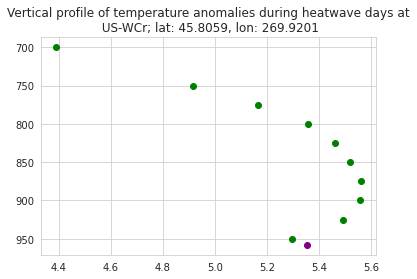

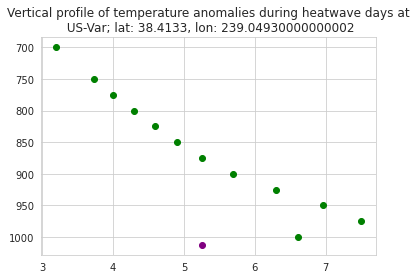

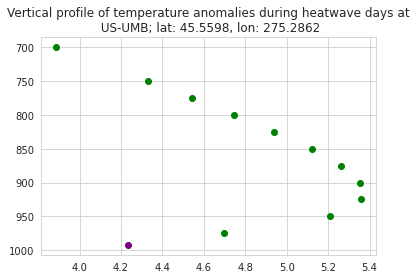

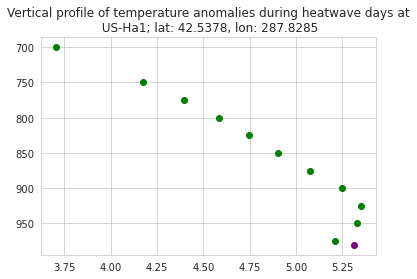

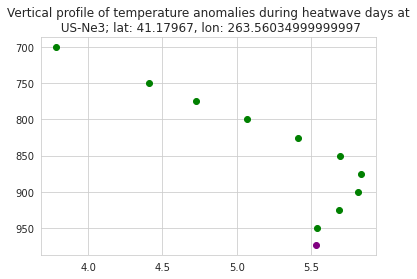

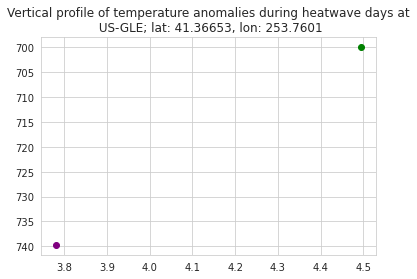

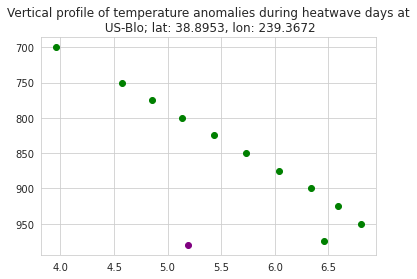

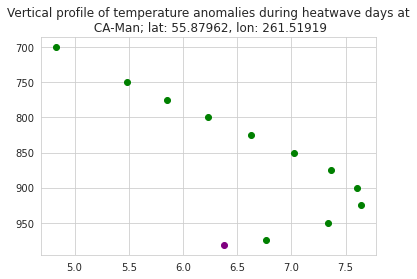

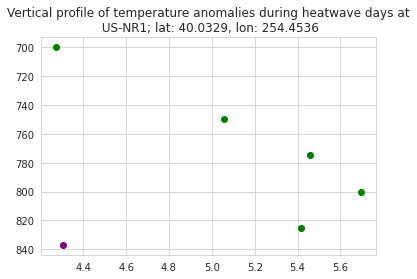

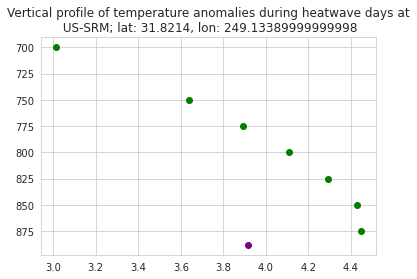

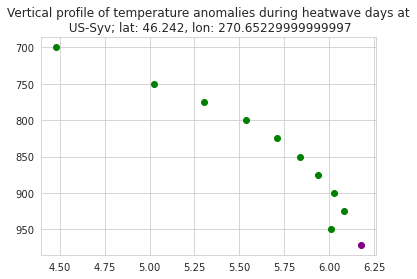

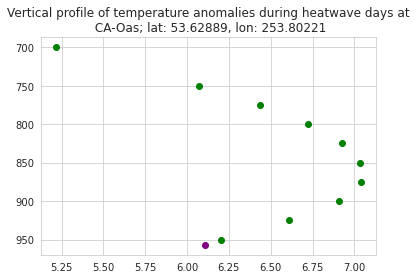

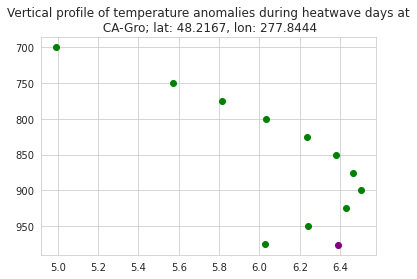

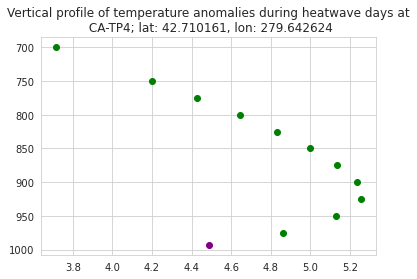

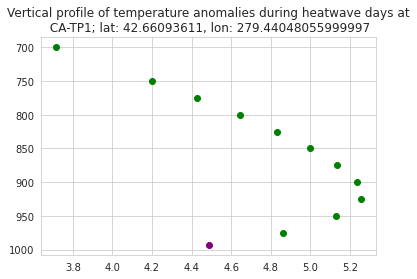

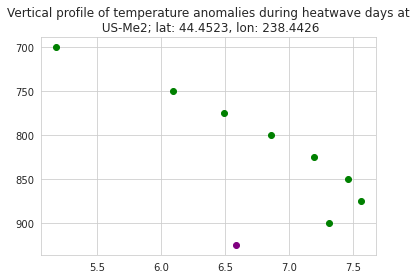

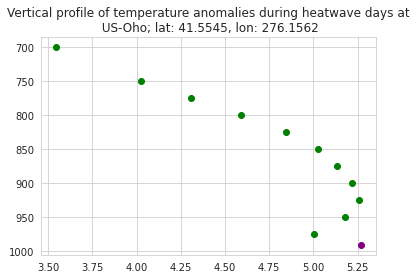

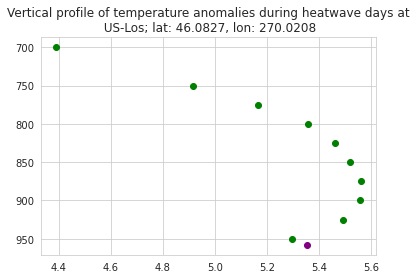

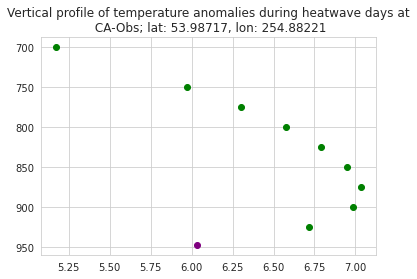

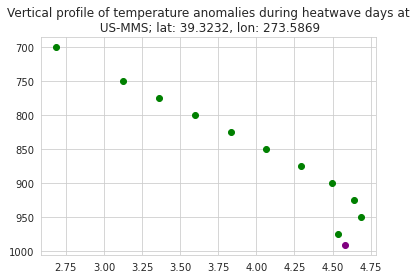

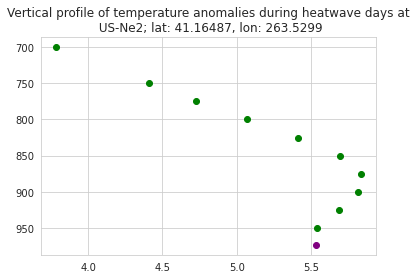

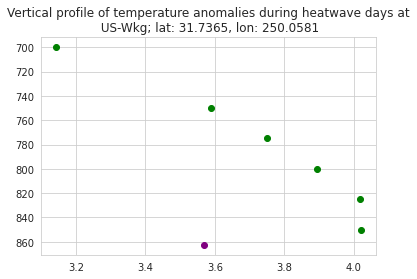

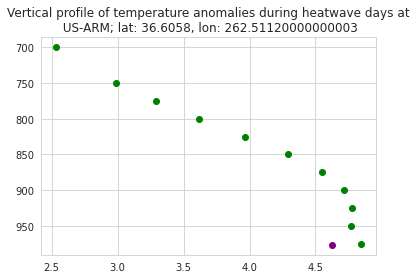

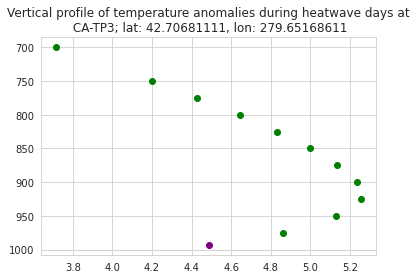

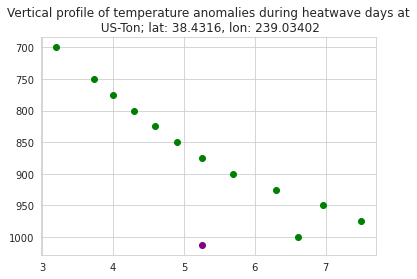

In [21]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    vertical_profile_non_std(ds.lat.item(), ds.lon.item(), name)

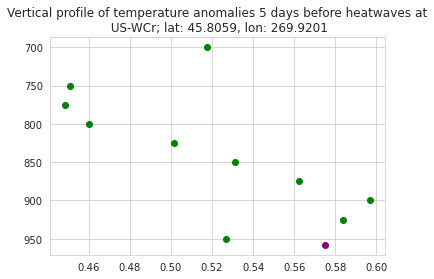

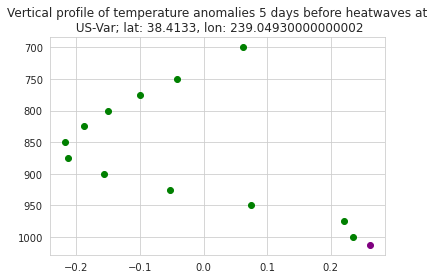

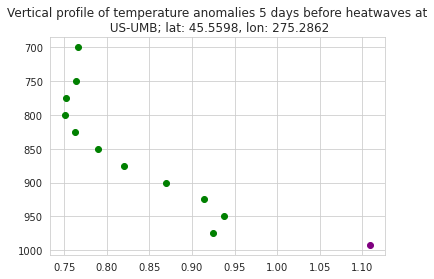

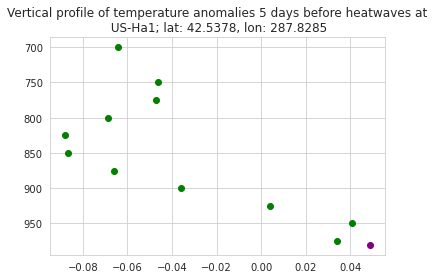

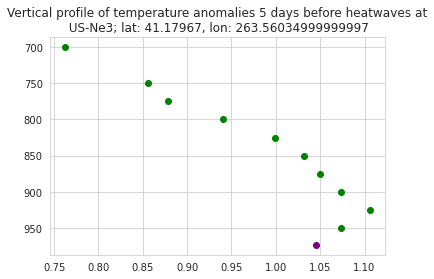

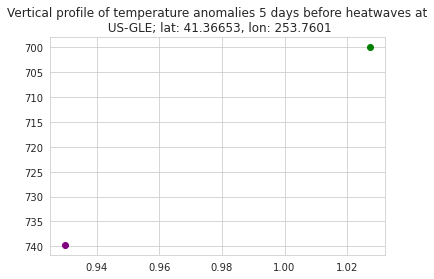

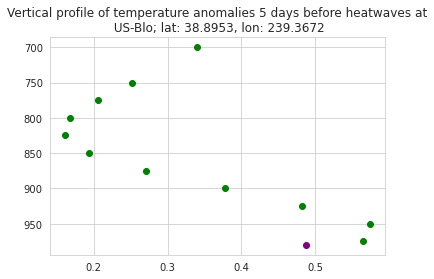

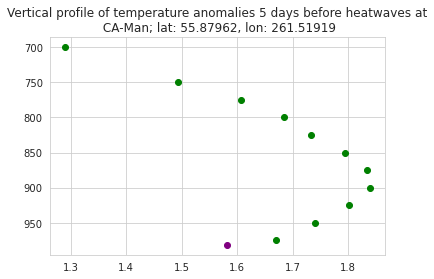

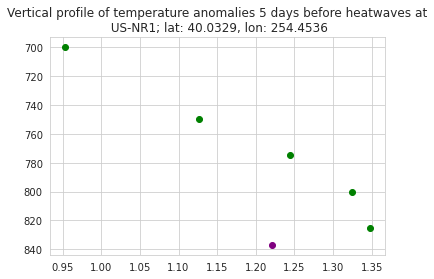

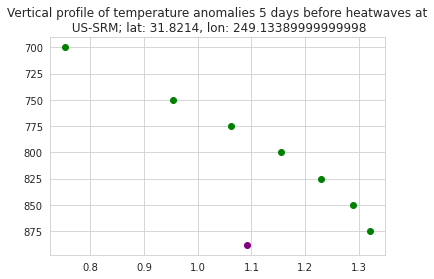

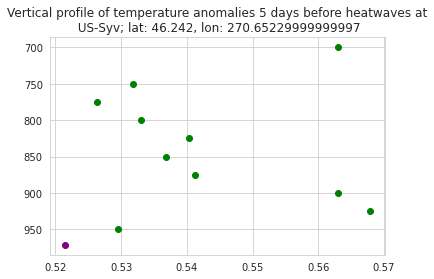

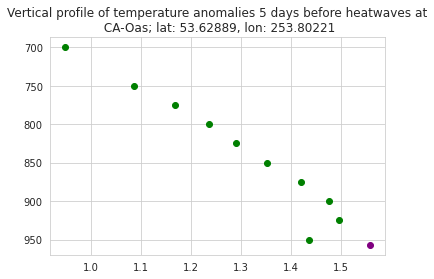

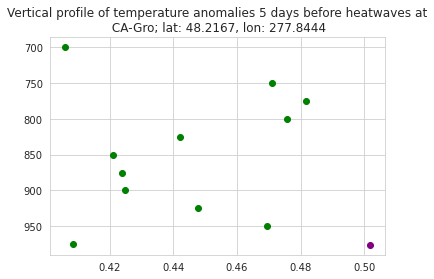

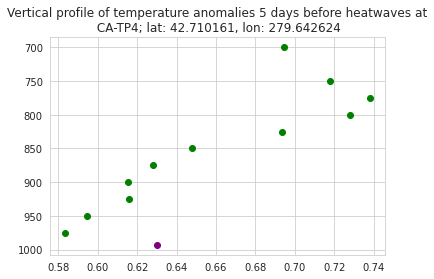

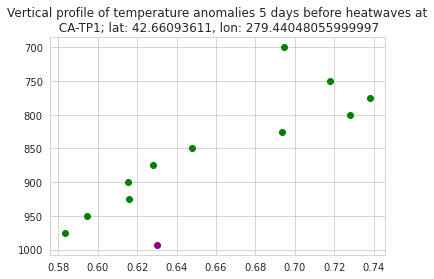

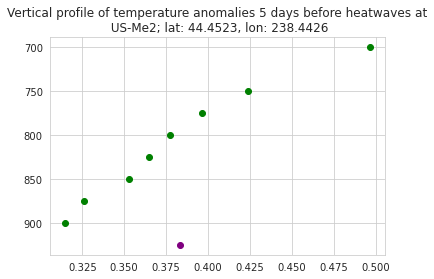

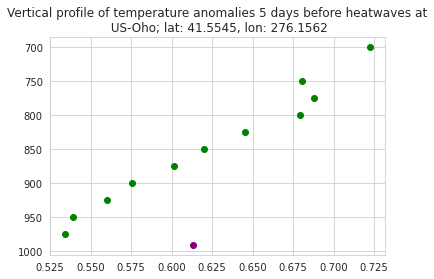

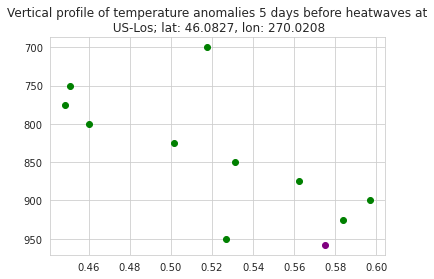

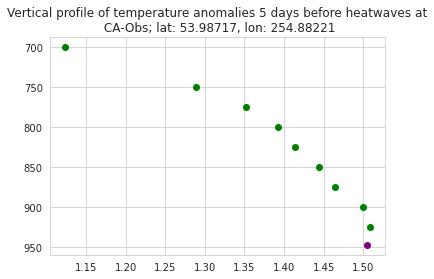

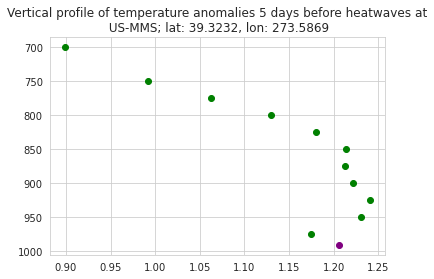

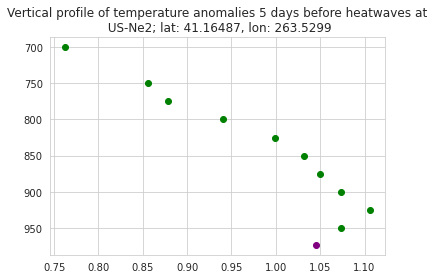

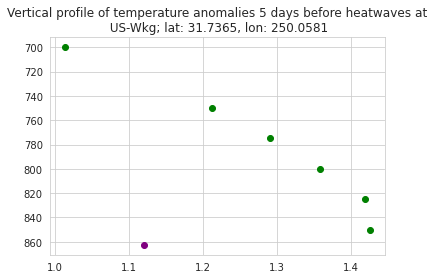

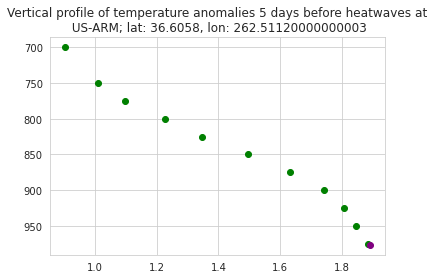

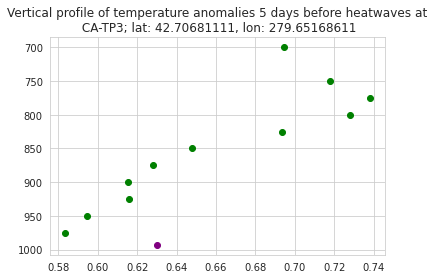

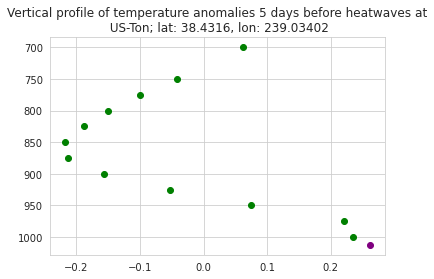

In [11]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    pre_vertical_profile_non_std(ds.lat.item(), ds.lon.item(), name)

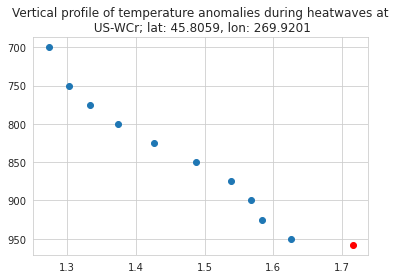

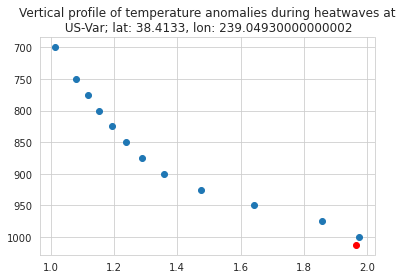

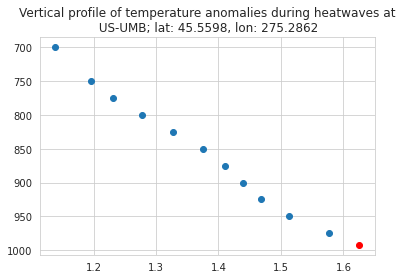

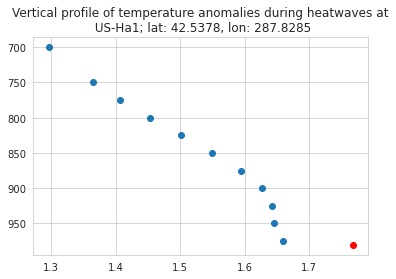

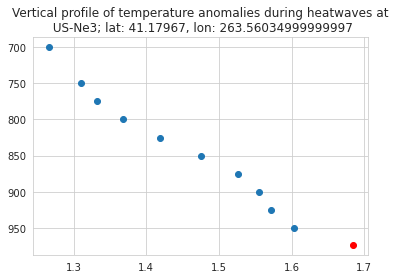

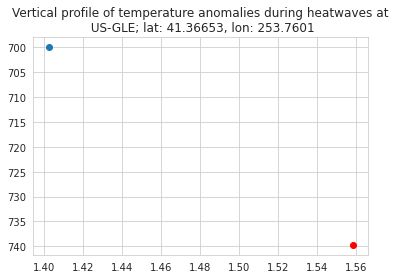

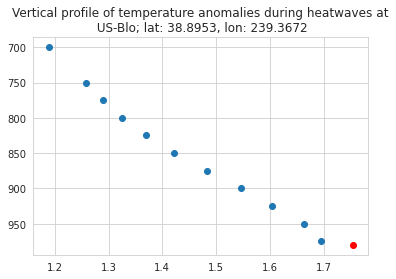

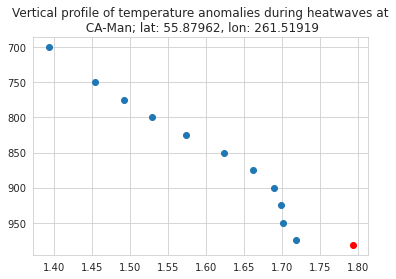

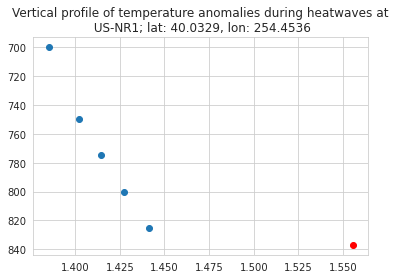

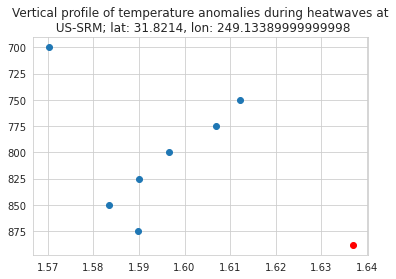

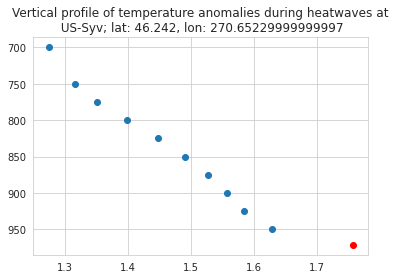

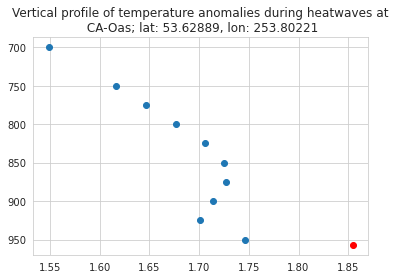

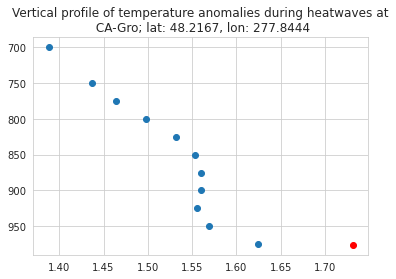

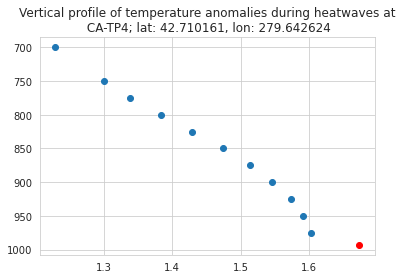

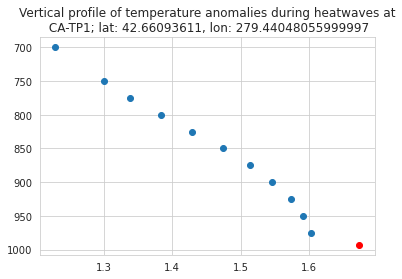

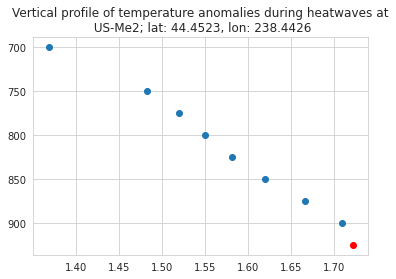

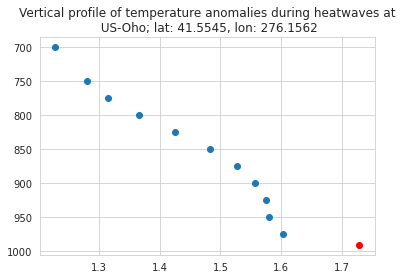

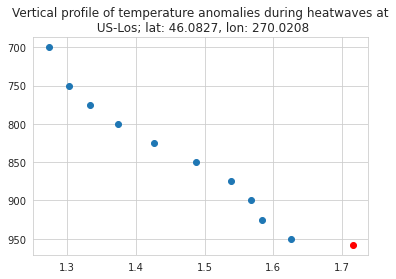

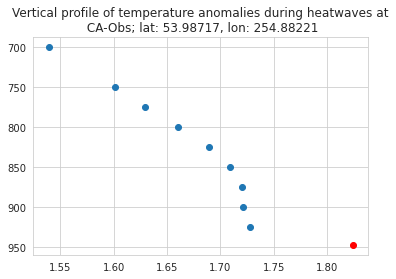

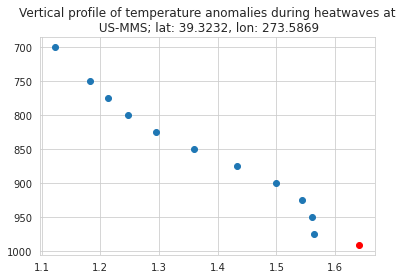

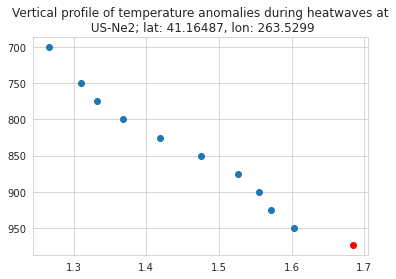

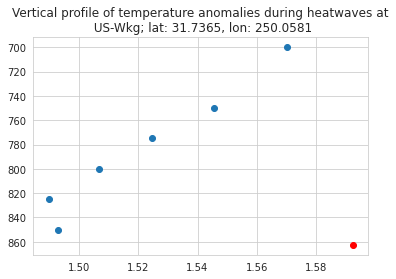

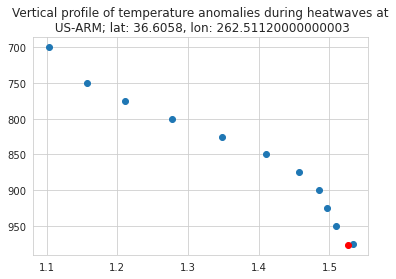

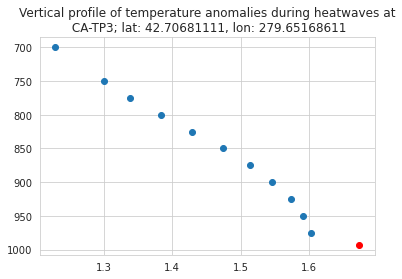

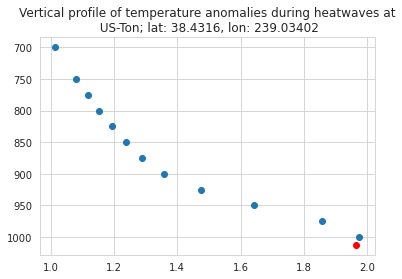

In [18]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    vertical_profile(ds.lat.item(), ds.lon.item(), name)

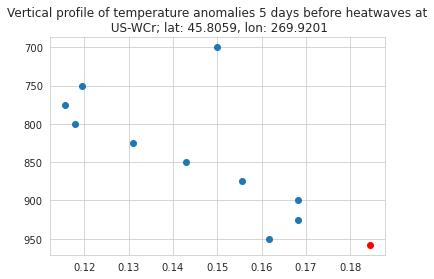

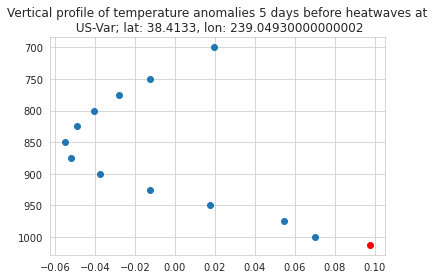

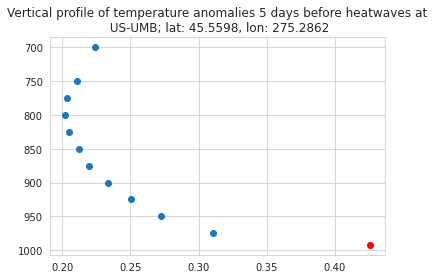

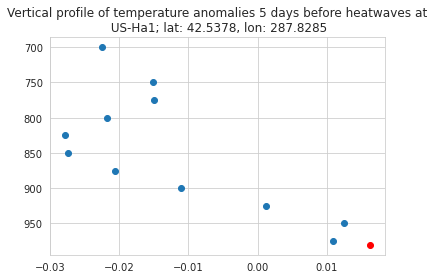

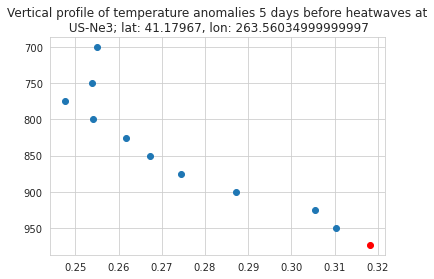

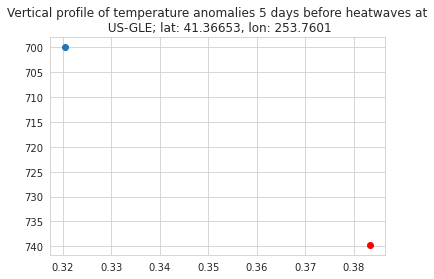

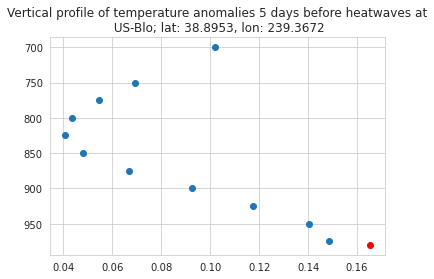

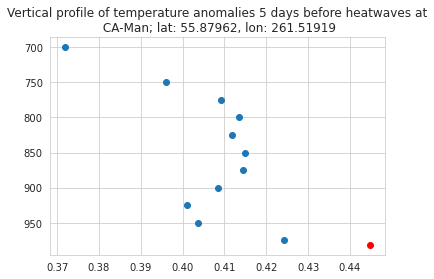

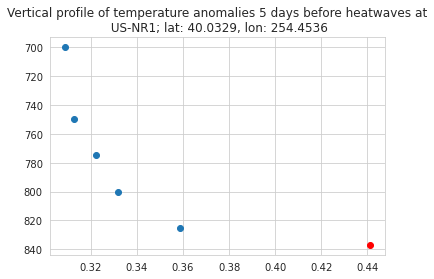

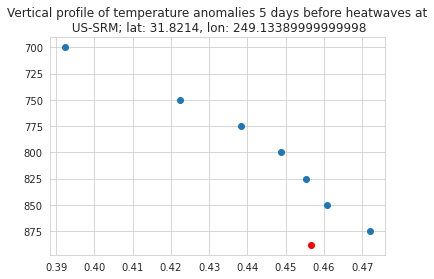

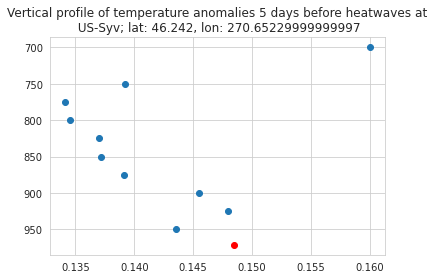

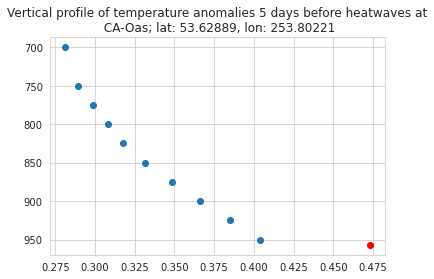

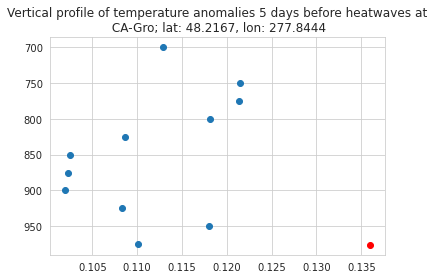

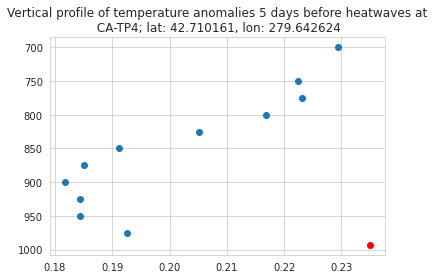

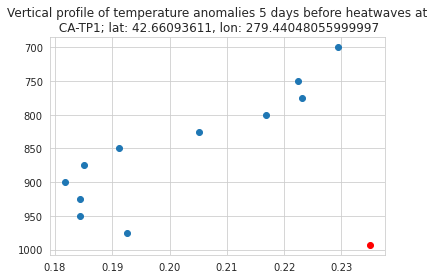

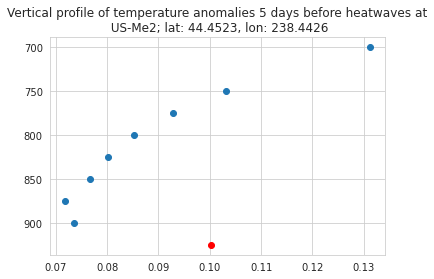

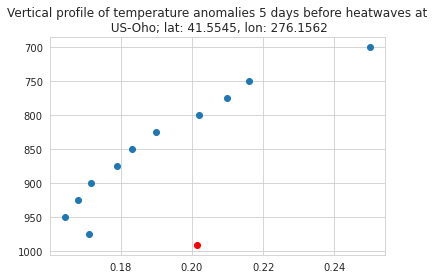

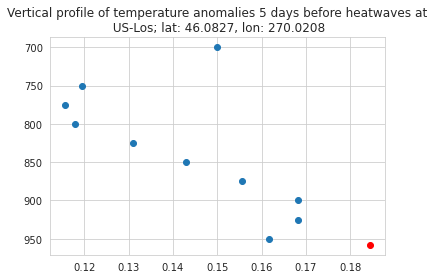

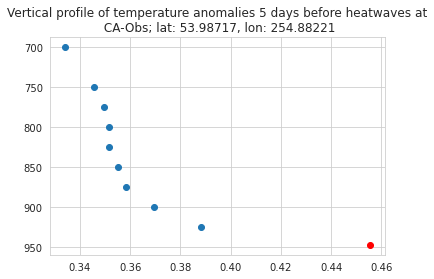

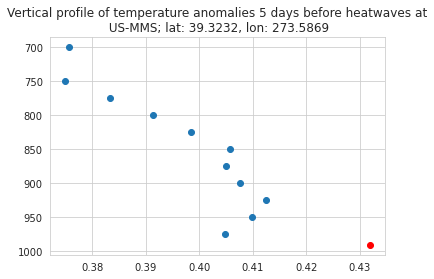

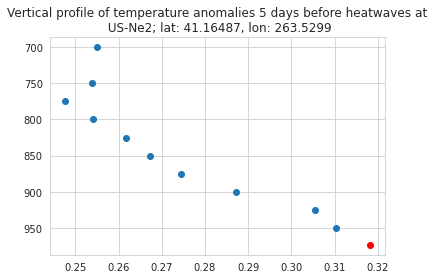

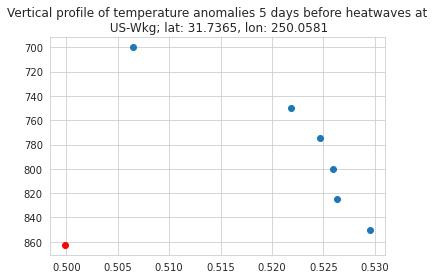

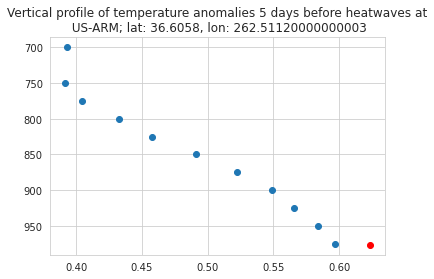

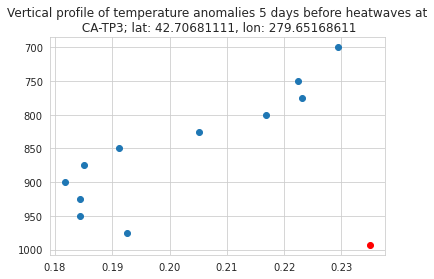

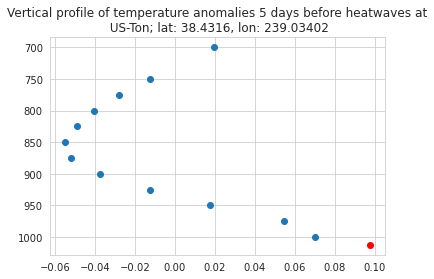

In [12]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    pre_hw_vertical_profile(ds.lat.item(), ds.lon.item(), name)